In [7]:
# initial setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# define come variables
color_fb = '#0000FF'
color_watch = '#00FF00'

df_raw=pd.read_csv('fb_apple.csv', index_col='date')

# only need to keep some of the columns
colnames = dict(steps='steps_fb', distance='dist_fb', steps_aw='steps_ap', dist_aw='dist_ap')
df = df_raw[['steps','distance','steps_aw','dist_aw', 'biking']].rename(columns=colnames)

# data prior to 6/1 is not generated by Apple Watch so remove it
df_watch = df[(df.steps_ap != ' NA') & (df.index >= '2015-06-01') & (df.index <= '2016-03-31')]

# values get read in as strings so convert them to numbers
df_watch = df_watch.convert_objects(convert_numeric=True)

# add the Steps Per Mile for both FB and AP
df_watch['spm_fb'] = df_watch['steps_fb'] / df_watch['dist_fb']
df_watch['spm_ap'] = df_watch['steps_ap'] / df_watch['dist_ap']

In [8]:
# data cleanup

# because I manually logged steps some days, the fitbit distances are wrong
# on those days and need to be re-computed. The are 10 days to be fixed.
df_watch.ix[df_watch.spm_fb > 2100, 'dist_fb'] = df_watch.steps_fb / 2042.
df_watch['spm_fb'] = df_watch['steps_fb'] / df_watch['dist_fb']

# Comparing Fitbit and Apple Watch Data

At the time I picked up an Apple Watch I had already been using a Fitbit for two years.  It was a habit I was reluctant to change. I was also concerned that there may not be any way to access the data from the Watch, and initially there was not. This is how I started wearing both devices, a practice that I continue with.

Now that there is a way to get data from both devices I decided it would be good to take a look at how the data compare.

# Data Sources

The Fitbit data comes initially from a Fitbit Flex and since November 22, 2015 from a Fitbit One (after the Flex died). For the Apple data, the data prior to June 1, 2015 came from the sensors in the iPhone 6 while the data after that date is from the Apple Watch.  Because the iPhone and Watch are such different devices, especially in how they are worn, I have separated these into 2 different data sets and in this analysis I will only look at the Watch data.

## Step Analysis
Since steps are the base data that all devices cover it seems natural to plot the steps from the devices against each other.

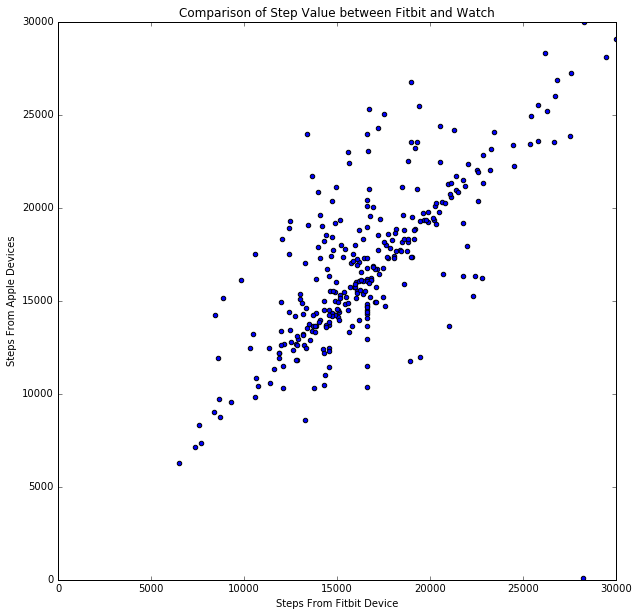

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,10) 
plt.scatter(df_watch.steps_fb, df_watch.steps_ap)
plt.xlim([0,30000])
plt.ylim([0,30000])
plt.title('Comparison of Step Value between Fitbit and Watch')
plt.xlabel('Steps From Fitbit Device')
plt.ylabel('Steps From Apple Devices')
plt.show()

There is a lot of commonality in the values reported but less than I expected. A better way of doing this may be to compute a percent difference between the two step values and look at these in a histogram.

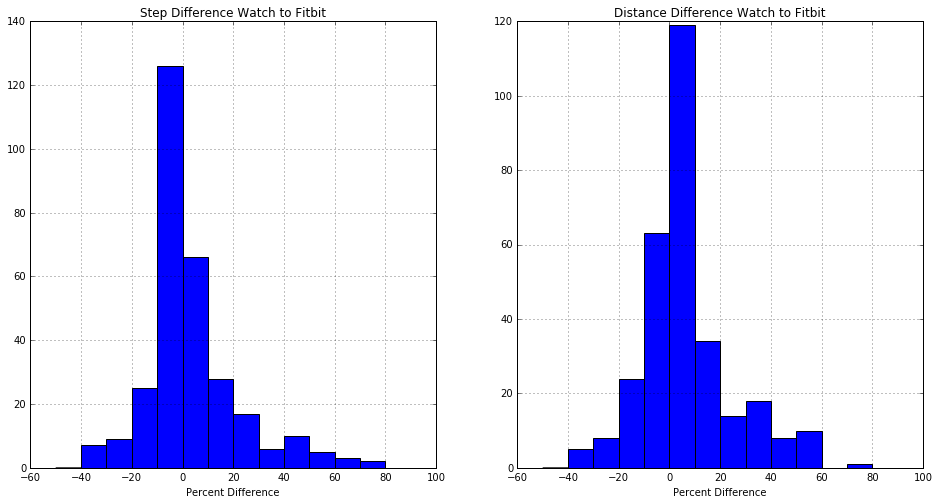

In [11]:
# Compute a difference in percent for histograms
df_watch['sdiff'] = 100*(df_watch.steps_ap - df_watch.steps_fb) / df_watch.steps_fb
df_watch['ddiff'] = 100*(df_watch.dist_ap - df_watch.dist_fb) / df_watch.dist_fb
#
plt.figure(1, figsize=(16,8))
plt.subplot(121) # numrows, numcols, fignum
df_watch.sdiff.hist(bins=np.arange(-50, 100, 10))
plt.title('Step Difference Watch to Fitbit')
plt.xlabel('Percent Difference')
plt.subplot(122)
df_watch.ddiff.hist(bins=np.arange(-50, 100, 10))
plt.title('Distance Difference Watch to Fitbit')
plt.xlabel('Percent Difference')
plt.show()

This gives us a better feel for the errors.  Much of the error in the steps is below 20% and while the error occurs on both sides, the tendency is that the Watch reads higher than the Fitbit. We also see that the error in the steps tend to be smaller than the errors in the distance which we will investigate also investigate.

While this histogram gives me some level of comfort that both devices give acceptable results the one thing this does not give us a good feeling for is whether we are accumulating differences over time.  This we can see by plotting the cumulative steps over time.

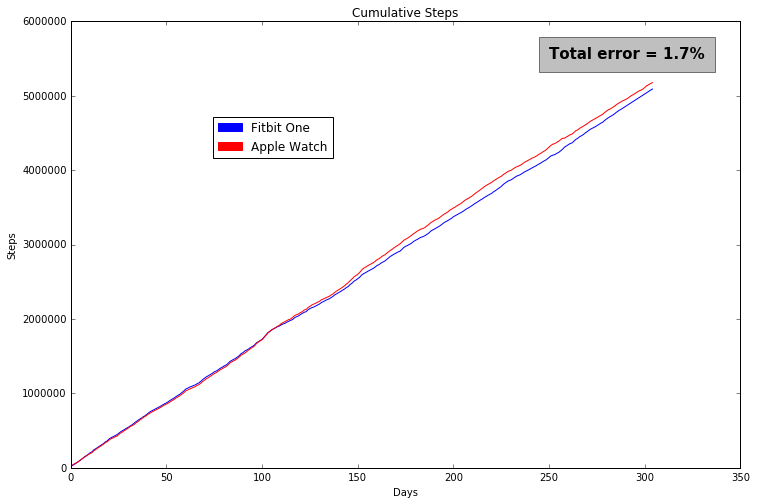

In [15]:
fb = df_watch.steps_fb.cumsum()

ap = df_watch.steps_ap.cumsum()
x = np.arange(len(ap))
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.plot(x, fb, 'b-',  x, ap, 'r-')
plt.title('Cumulative Steps')
plt.ylabel('Steps')
plt.xlabel('Days')
fb_patch = mpatches.Patch(color='blue', label='Fitbit One')
ap_patch = mpatches.Patch(color='red', label='Apple Watch')
plt.legend(handles=[fb_patch, ap_patch], bbox_to_anchor=[0.4,0.8])
plt.gca().text(250, 5500000, 'Total error = 1.7%', fontweight='bold', fontsize=15,
        bbox={'facecolor':'grey', 'alpha':0.5, 'pad':10})
plt.show()

Looking at the data this way give me comfort that both devices do an equally good job of tracking steps. There are times when I wear my Watch but I'm not wearing my Fitbit (often while cycling) and I have no trouble believing that the actually difference between the two would be lower than the 1.7% shown here if I could account for that.

## Distance Analysis
Not that we see how well steps match let's look at the distance computed by these devices. Since the Fitbit has no way to measure distance it has to perform a conversion from steps to distance.  The Watch and iPhone combination have significantly more sensor data to work with and I don't know how it actually determines the distance it logs.

Let's look at the steps-per-mile that result from dividing the steps by the distance in miles generated by both devices.

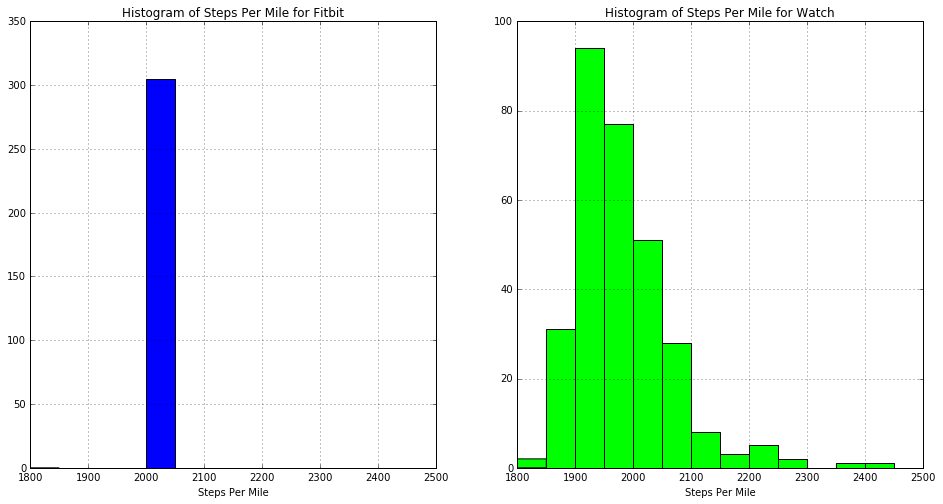

In [16]:
plt.figure(1, figsize=(16,8))
plt.subplot(121) # numrows, numcols, fignum
df_watch.spm_fb.hist(bins=np.arange(1800, 2500, 50), color=color_fb)
plt.title('Histogram of Steps Per Mile for Fitbit')
plt.xlabel('Steps Per Mile')
plt.subplot(122)
df_watch.spm_ap.hist(bins=np.arange(1800, 2500, 50), color=color_watch)
plt.title('Histogram of Steps Per Mile for Watch')
plt.xlabel('Steps Per Mile')
plt.show()

This is a very clear indication on how different distance is handled by both devices. Whereas the distance produced by the Fitbit has a very simple relationship to the steps, in the case of the Watch the number of steps-per-mile varies significantly.

If the Watch is trying to actually measure the distance using the GPS I could see 2 sources for the variation in steps-per-mile.  The first is just stride differences due to walking speed. A larger possible source of error could be how the watch determines whether you are walking or doing some other activity. Since I wear the watch cycling I wanted to see if the steps-per-mile variation was different on days I wore the Watch cycling from those where I did not.

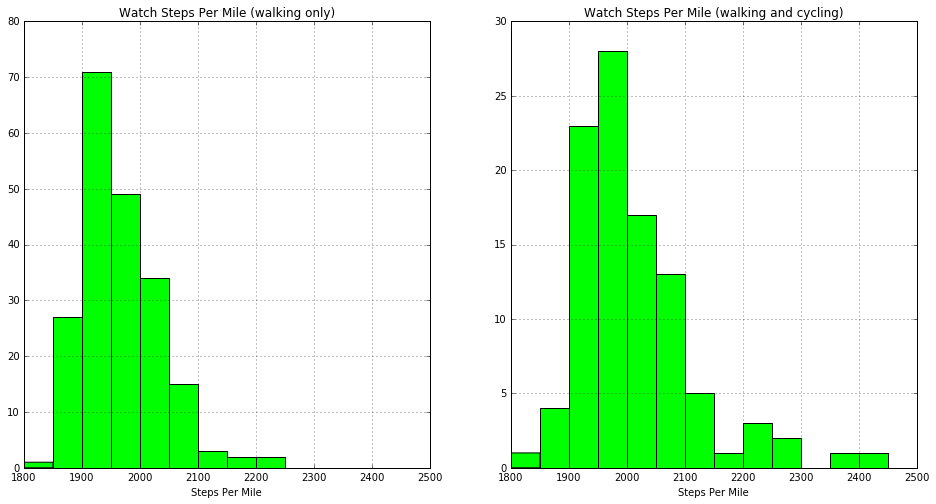

In [18]:
plt.figure(1, figsize=(16,8))
plt.subplot(121) # numrows, numcols, fignum
df_watch[df_watch.biking.isnull()].spm_ap.hist(bins=np.arange(1800, 2500, 50), color=color_watch)
plt.title('Watch Steps Per Mile (walking only)')
plt.xlabel('Steps Per Mile')
plt.subplot(122)
df_watch[df_watch.biking>0].spm_ap.hist(bins=np.arange(1800, 2500, 50), color=color_watch)
plt.title('Watch Steps Per Mile (walking and cycling)')
plt.xlabel('Steps Per Mile')
plt.show()

As I suspected, the grouping of steps-per-mile is much worse on cycling days. If the goal is to get an accurate walking distance from an Apple Watch it clearly should not be worn while cycling.

# Conclusions

Through this exercise I've gained confidence that I could replace my Fitbit with my Watch. The path to get data is a solved problem and the step data matches the Fitbit quite well.

I consider the distance differences a toss-up. Getting distance from a the simple computation of dividing steps is at best an approximation. For walkers it is acceptable but for runners this won't work as their walking and running strides will be so different. If you plan to run, as well as walk I would expect the Watch to produce much better results. A Fitbit model with built-in GPS would also be an option.

# Source Material

For those interested, this post is provided as a Jupyter Notebook document.